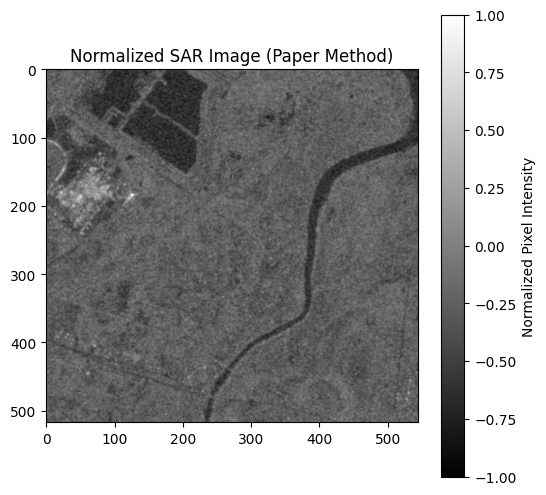

In [47]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Load .tif file
tif_path = "/home/alex/Desktop/miniproject/VH.tif"

with rasterio.open(tif_path) as src:
    image = src.read(1).astype(np.float32)  # Read the first band

# Apply log transformation as per the paper
image = 10 * np.log10(image + 1e-6) + 50  

image = (image - np.min(image)) / (np.max(image) - np.min(image))  
image = (image * 2) - 1  

# Display image
plt.figure(figsize=(6,6))
plt.imshow(image, cmap="gray")
plt.colorbar(label="Normalized Pixel Intensity")
plt.title("Normalized SAR Image (Paper Method)")
plt.show()


In [ ]:
import os
import random
import shutil

# Set the directories relative to the working directory
labels_dir = 'archive/sen12flood/sen12floods_s1_labels/sen12floods_s1_labels'
source_dir = 'archive/sen12flood/sen12floods_s1_source/sen12floods_s1_source'

# List and sort the label directories for reproducibility
label_dirs = sorted([d for d in os.listdir(labels_dir) if os.path.isdir(os.path.join(labels_dir, d))])

# Shuffle and select half of the directories to delete
random.shuffle(label_dirs)
num_to_delete = len(label_dirs) // 2
dirs_to_delete = label_dirs[:num_to_delete]

deleted_pairs = 0

for dirname in dirs_to_delete:
    label_path = os.path.join(labels_dir, dirname)
    # Replace label prefix with source prefix to form the corresponding source directory name
    source_dirname = dirname.replace("sen12floods_s1_labels", "sen12floods_s1_source", 1)
    source_path = os.path.join(source_dir, source_dirname)
    
    # Only delete if both the label and source directories exist
    if os.path.isdir(label_path) and os.path.isdir(source_path):
        shutil.rmtree(label_path)
        shutil.rmtree(source_path)
        deleted_pairs += 1
        print(f"Deleted pair: {label_path} and {source_path}")
    else:
        print(f"Skipping {dirname}: Pair not found (label exists: {os.path.isdir(label_path)}, source exists: {os.path.isdir(source_path)})")

print(f"Total deleted pairs: {deleted_pairs}")

In [ ]:
import os
import torch
import numpy as np
import rasterio
import json
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class FloodDataset(Dataset):
    def __init__(self, source_dir, labels_dir, target_size=(512, 512), transform=None):
        self.source_dir = source_dir
        self.labels_dir = labels_dir
        self.target_size = target_size  # Fixed size for all images
        self.transform = transform
        
        # Get list of SAR image directories (sorted for consistency)
        self.sample_ids = sorted(os.listdir(source_dir))
        
    def __len__(self):
        return len(self.sample_ids)
    
    def preprocess_sar(self, image):
        """Apply log transformation and normalize to [-1,1]."""
        # Apply log transformation first
        image = 10 * np.log10(image + 1e-6) + 50  # Avoid log(0)
        
        # Compute denominator safely
        img_min = np.min(image)
        img_max = np.max(image)
        denom = img_max - img_min
        if denom < 1e-6:
            # If the image has no contrast, set it to zeros
            image = np.zeros_like(image)
        else:
            image = (image - img_min) / denom  # Normalize to [0,1]
        
        # Scale to [-1,1]
        image = (image * 2) - 1
        return image.astype(np.float32)

    
    def get_flood_label(self, label_path):
        """Read labels.geojson and return flood label (0 or 1)."""
        if not os.path.exists(label_path):
            print(f"Warning: Missing label file {label_path}")
            return 0  # Default to no flood if label is missing
        
        with open(label_path, "r") as f:
            label_data = json.load(f)
        return 1 if label_data["properties"].get("FLOODING", False) else 0
    
    def __getitem__(self, idx):
        sample_id = self.sample_ids[idx]
        sample_dir = os.path.join(self.source_dir, sample_id)
        
        # Find VH.tif within the sample directory (search recursively)
        vh_file = None
        for root, dirs, files in os.walk(sample_dir):
            if "VH.tif" in files:
                vh_file = os.path.join(root, "VH.tif")
                break
        if vh_file is None:
            raise FileNotFoundError(f"VH.tif not found in directory: {sample_dir}")
        image_path = vh_file
        
        # Construct label path by replacing source with labels in the directory name
        label_subdir = sample_id.replace("sen12floods_s1_source", "sen12floods_s1_labels")
        label_path = os.path.join(self.labels_dir, label_subdir, "labels.geojson")
        
        # Check if label file exists
        if not os.path.exists(label_path):
            print(f"Warning: Missing label for {sample_id}, skipping.")
            return self.__getitem__((idx + 1) % len(self.sample_ids))
        
        # Load SAR image
        with rasterio.open(image_path) as src:
            image = src.read(1).astype(np.float32)  # Read single-band VH SAR image
        image = self.preprocess_sar(image)
        
        # Convert the numpy array to a torch tensor and add channel dimension: (1, H, W)
        image = torch.tensor(image).unsqueeze(0)
        # Resize image to target size (batch stacking requires same size)
        image = F.interpolate(image.unsqueeze(0), size=self.target_size, mode='bilinear', align_corners=False).squeeze(0)
        
        # Load flood label (global scalar label: 0 or 1)
        flood_label = self.get_flood_label(label_path)
        label = torch.tensor(flood_label, dtype=torch.float32)
        
        return image, label

# Example usage:
# Ensure these directories point to the folders that directly contain your sample subdirectories.
dataset = FloodDataset(
    source_dir="/home/alex/Desktop/miniproject/archive/sen12flood/sen12floods_s1_source/sen12floods_s1_source", 
    labels_dir="/home/alex/Desktop/miniproject/archive/sen12flood/sen12floods_s1_labels/sen12floods_s1_labels",
    target_size=(512, 512)
)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Check a sample:
sample_image, sample_label = dataset[0]
print("Image shape:", sample_image.shape)  # Expected: (1, 512, 512)
print("Flood label:", sample_label)  # 0 or 1


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = self.double_conv(in_channels, 64)
        self.enc2 = self.double_conv(64, 128)
        self.enc3 = self.double_conv(128, 256)
        self.enc4 = self.double_conv(256, 512)
        
        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)
        
        # Decoder
        self.upconv4 = self.upconv(1024, 512)
        self.dec4 = self.double_conv(1024, 512)
        self.upconv3 = self.upconv(512, 256)
        self.dec3 = self.double_conv(512, 256)
        self.upconv2 = self.upconv(256, 128)
        self.dec2 = self.double_conv(256, 128)
        self.upconv1 = self.upconv(128, 64)
        self.dec1 = self.double_conv(128, 64)
        
        # Output layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.downsample(e1))
        e3 = self.enc3(self.downsample(e2))
        e4 = self.enc4(self.downsample(e3))
        
        # Bottleneck
        b = self.bottleneck(self.downsample(e4))
        
        # Decoder
        d4 = self.upconv4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        # Output
        return torch.sigmoid(self.final_conv(d1))
    
    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def downsample(self, x):
        return F.max_pool2d(x, kernel_size=2, stride=2)
    
    def upconv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

# Example: Initialize the model
model = UNet(in_channels=1, out_channels=1)
print(model)


In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Device configuration: use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the UNet model and move it to the device
model = UNet(in_channels=1, out_channels=1).to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Update DataLoader settings to reduce memory usage
# Using a smaller batch size and num_workers=0 ensures minimal memory load.
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0)

num_epochs = 20
total_start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        # Adjust labels shape to (batch, 1)
        labels = labels.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        
        # Forward pass: model outputs shape (batch, 1, H, W)
        outputs = model(images)
        
        # Global average pooling to get a single prediction per image
        outputs = torch.mean(outputs, dim=(2,3))  # Now shape: (batch, 1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_time = time.time() - epoch_start
    epoch_loss = running_loss / len(dataset)
    remaining_epochs = num_epochs - epoch - 1
    estimated_remaining_time = remaining_epochs * epoch_time
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Epoch Time: {epoch_time:.2f} sec, "
          f"Estimated Remaining Time: {estimated_remaining_time:.2f} sec")

total_time = time.time() - total_start_time
print(f"Training complete in {total_time/60:.2f} minutes.")

torch.save(model.state_dict(), "unet_flood_model.pth")
print("Model saved as unet_flood_model.pth")


Otsu threshold: -0.35646772


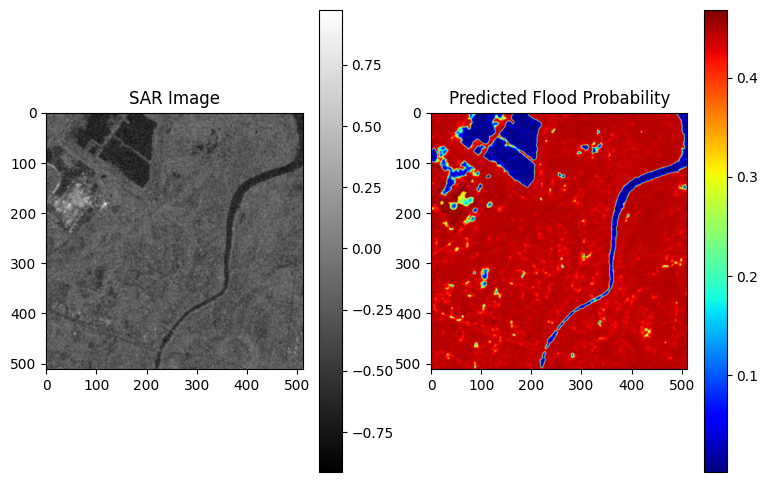

In [44]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, remove_small_holes, closing, disk


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load("unet_flood_model.pth", map_location=device))
model.eval()  # Set model to evaluation mode

# -----------------------------------------------------------------------------------
# 2) IMAGE LOADING
# -----------------------------------------------------------------------------------
def load_sar_image(image_path, target_size=(512, 512)):
    """
    Load SAR image from file, preprocess it, and resize it to a compatible size.
    """
    with rasterio.open(image_path) as src:
        image = src.read(1).astype(np.float32)
    
    # Apply log transformation and normalize to [-1,1]
    image = 10 * np.log10(image + 1e-6) + 50
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    image = (image * 2) - 1
    
    
    image = torch.tensor(image).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, H, W)

    
    image = F.interpolate(image, size=target_size, mode="bilinear", align_corners=False)

    return image

# -----------------------------------------------------------------------------------
# 3) IMPROVED OTSU MASK CREATION
# -----------------------------------------------------------------------------------
def create_ground_truth_from_sar(sar_image_tensor):
    """
    Create a synthetic water mask from the SAR image using Otsu's threshold.
    Then apply morphological operations to reduce noise and improve continuity.
    """
    # Remove batch and channel dimensions and convert to numpy
    sar_image = sar_image_tensor.cpu().squeeze().numpy()
    
    # Compute threshold using Otsu's method
    otsu_thresh = threshold_otsu(sar_image)
    print("Otsu threshold:", otsu_thresh)
    
    # Create binary mask: water is assumed to have values below the threshold
    water_mask = (sar_image < otsu_thresh).astype(np.uint8)
    
    
    selem = disk(3)  
    water_mask = closing(water_mask, selem)
    water_mask = remove_small_objects(water_mask.astype(bool), min_size=64)
    water_mask = remove_small_holes(water_mask, area_threshold=64)
    
    # Convert boolean mask back to uint8 (0 or 1)
    water_mask = water_mask.astype(np.uint8)
    
    return water_mask


image_path = "VH.tif"
test_image = load_sar_image(image_path, target_size=(512, 512))  # Ensure correct input size


synthetic_gt = create_ground_truth_from_sar(test_image)

# -----------------------------------------------------------------------------------
# 5) MODEL INFERENCE
# -----------------------------------------------------------------------------------
with torch.no_grad():
    pred_mask = model(test_image)

# Convert prediction to numpy
pred_mask_np = pred_mask.cpu().squeeze().numpy()

# Threshold the model's output to create a binary flood mask
threshold_value = 0.5  
binary_mask = (pred_mask_np > threshold_value).astype(int)


binary_mask = 1 - binary_mask

# -----------------------------------------------------------------------------------
# 6) EVALUATION (Flood Score & Accuracy)
# -----------------------------------------------------------------------------------
# Flood Score: percentage of non-flooded pixels (value=1) in the inverted mask
non_flooded_fraction = (binary_mask.sum() / binary_mask.size) * 100


# -----------------------------------------------------------------------------------
# 7) VISUALIZATION
# -----------------------------------------------------------------------------------
plt.figure(figsize=(24,6))

# Original SAR Image
plt.subplot(1,5,1)
plt.imshow(test_image.cpu().squeeze(), cmap="gray")
plt.title("SAR Image")
plt.colorbar()

# Predicted Flood Probability
plt.subplot(1,5,2)
plt.imshow(pred_mask_np, cmap="jet")
plt.title("Predicted Flood Probability")
plt.colorbar()



plt.show()
